# Marco Lavorini - Assignment 3

### dataset
Vito,Saverio. (2016). Air Quality. UCI Machine Learning Repository. https://doi.org/10.24432/C59K5F.

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Fetching the dataset

In [75]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets 
  
# metadata 
print(air_quality.metadata) 


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 'S. D. Vito, E. Massera, M. P

In [76]:
# drop columns except for the target column 
df = X.drop(['Date','Time','CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH', 'AH'], axis=1)
df = df[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'C6H6(GT)']]
# the null values are marked as '-200'
df = df[df['C6H6(GT)'] != -200]
df = df[df['PT08.S1(CO)'] != -200]
df = df[df['PT08.S2(NMHC)'] != -200]
df = df[df['PT08.S3(NOx)'] != -200]
df = df[df['PT08.S4(NO2)'] != -200]
df = df[df['PT08.S5(O3)'] != -200]


In [77]:
df.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),C6H6(GT)
0,1360,1046,1056,1692,1268,11.9
1,1292,955,1174,1559,972,9.4
2,1402,939,1140,1555,1074,9.0
3,1376,948,1092,1584,1203,9.2
4,1272,836,1205,1490,1110,6.5


# Data splitting

we decided to split the dataset, leaving a 20% of the data out, untouched, for testing. The remaining data was further divided in 80% for train and 20% for validation.

In [78]:
# split into train and test sets
dataset = df.values

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
validation_size = int(train_size * 0.2)
train_size = train_size - validation_size

print(f'train: {train_size}, validation: {validation_size}, test: {test_size}')

train: 5754, validation: 1438, test: 1799


The data was scaled only on the true train test, without the validation or test set. This is done to fit the scaler only on the training set without the 'future' data which in a real scenario should not be known.

In [79]:
# normalize the dataset
X_ = dataset[:, :-1]
y_ = dataset[:, -1]
train_X, train_y = X_[:train_size], y_[:train_size]
validation_X, validation_y = X_[train_size:train_size+validation_size], y_[train_size:train_size+validation_size]
test_X, test_y = X_[train_size+validation_size:], y_[train_size+validation_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
validation_X = scaler.transform(validation_X)
test_X = scaler.transform(test_X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
validation_y = scaler_y.transform(validation_y.reshape(-1, 1))
test_y = scaler_y.transform(test_y.reshape(-1, 1))

# First model: LSTM

We choose an LSTM neural network as the first model to predict the benzene, based on the PT08.* measurement. To create the model we used Keras which offers an easy LSTM layer implementation [2] in the standard Sequential model. The data is then reshaped accordingly to the documentation where it must have the shape (batch, timesteps, feature).

[2] https://keras.io/api/layers/recurrent_layers/lstm/

In [80]:
print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape, test_X.shape, test_y.shape)

# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
validation_X = np.reshape(validation_X, (validation_X.shape[0], 1, validation_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape, test_X.shape, test_y.shape)

(5754, 5) (5754, 1) (1438, 5) (1438, 1) (1799, 5) (1799, 1)
(5754, 1, 5) (5754, 1) (1438, 1, 5) (1438, 1) (1799, 1, 5) (1799, 1)


In [81]:
model =  Sequential()

model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(3))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')


In [82]:
print(model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 3)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112 (448.00 B)

 Trainable params: 112 (448.00 B)

 Non-trainable params: 0 (0.00 B)

None


# Training the first model

It is important to notice that here the parameter 'shuffle' was set to False since we are working with a time-series.

In [83]:
history = model.fit(train_X, train_y, validation_data=[validation_X, validation_y], epochs=20, batch_size=50, verbose=False, shuffle=False)

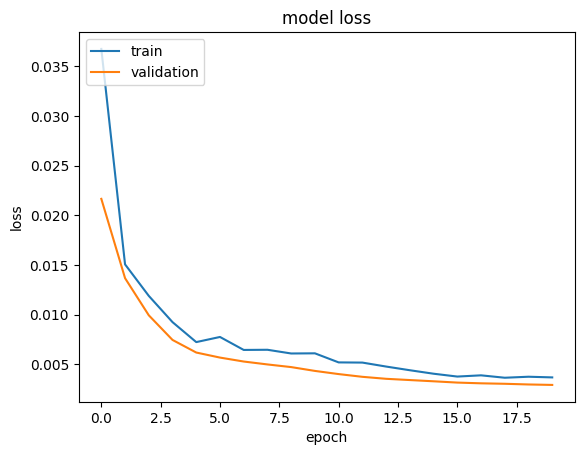

In [84]:
# print the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


Rescaling the data back

In [49]:
predict = model.predict(test_X)
predict = scaler_y.inverse_transform(predict)
test_y = scaler_y.inverse_transform(test_y)
rmse = math.sqrt(mean_squared_error(test_y, predict))
print('Test RMSE: %.3f' % rmse)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(1799, 1)

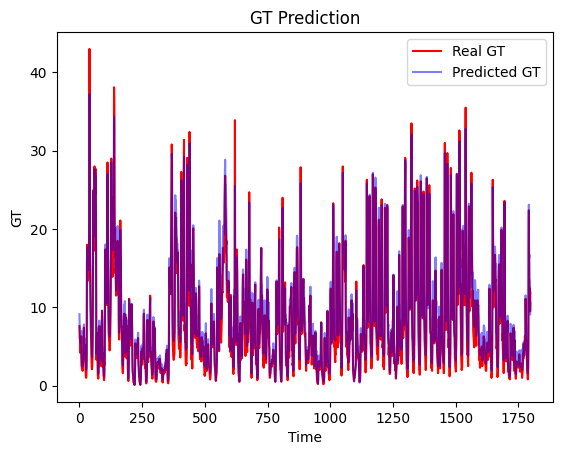

In [51]:
# plot the data
plt.plot(test_y, color = 'red', label = 'Real GT')
plt.plot(predict, color = 'blue', label = 'Predicted GT', alpha=0.5)
plt.title('GT Prediction')

plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.show()

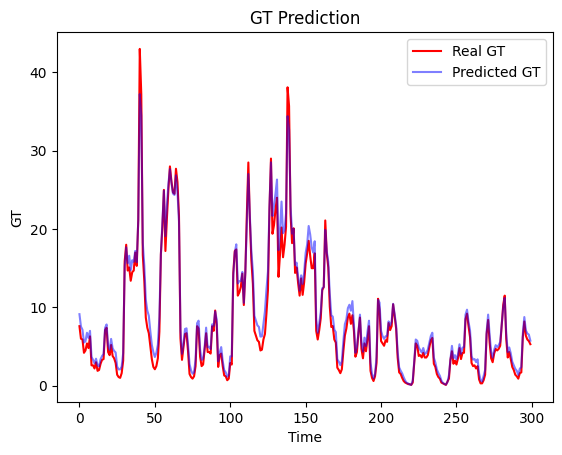

In [52]:
# plot the prediction more readable
plt.plot(test_y[0:300], color = 'red', label = 'Real GT')
plt.plot(predict[0:300], color = 'blue', label = 'Predicted GT', alpha=0.5)
plt.title('GT Prediction')

plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.show()

---

# second model

create the dataset with x 

In [53]:
X_2, y_2 = [], []
for i in range(len(y_)-1):
    X_2.append(y_[i])
    y_2.append(y_[i+1])
X_2 = np.array(X_2)
y_2 = np.array(y_2)

In [54]:
print(X_2.shape, y_2.shape)

(8990,) (8990,)


In [55]:
# split into train and test sets
dataset = df.values

train_size = int(len(X_2) * 0.8)
test_size = len(X_2) - train_size
validation_size = int(train_size * 0.2)
train_size = train_size - validation_size

print(train_size, validation_size, test_size)
print(len(X_2))
print(train_size + validation_size + test_size)

5754 1438 1798
8990
8990


In [56]:
x_train, y_train = X_2[:train_size], y_2[:train_size]
x_validation, y_validation = X_2[train_size:train_size+validation_size], y_2[train_size:train_size+validation_size]
x_test, y_test = X_2[train_size+validation_size:], y_2[train_size+validation_size:]

In [57]:
x_train = scaler.fit_transform(x_train.reshape(-1, 1))
x_validation = scaler.transform(x_validation.reshape(-1, 1))
x_test = scaler.transform(x_test.reshape(-1, 1))

y_train = scaler.transform(y_train.reshape(-1, 1))
y_validation = scaler.transform(y_validation.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))


In [58]:
print(x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape)

(5754, 1) (5754, 1) (1438, 1) (1438, 1) (1798, 1) (1798, 1)


In [61]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

x_validation = np.reshape(x_validation, (x_validation.shape[0], 1, x_validation.shape[1]))

x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape)

(5754, 1, 1) (5754, 1) (1438, 1, 1) (1438, 1) (1798, 1, 1) (1798, 1)


# model 2, the same for different data

In [62]:
model2 =  Sequential()

model2.add(LSTM(1, input_shape=(x_train.shape[1], x_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(Dense(1))

c:\Users\chucki\Desktop\projects\ISPR-Midterms\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [63]:
model2.compile(loss='mean_squared_error', optimizer='adam')

In [64]:
print(model2.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [65]:
history = model2.fit(x_train, y_train, validation_data=[x_validation, y_validation], epochs=20, batch_size=50, verbose=1, shuffle=False)

Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0397 - val_loss: 0.0261
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - val_loss: 0.0196
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - val_loss: 0.0183
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - val_loss: 0.0172
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - val_loss: 0.0159
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134 - val_loss: 0.0146
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.0132
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.0118
Epoch 9/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 10/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - val_loss: 0.0093
Epoch 11/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096 - val_loss: 0.0085
Epoch 12/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

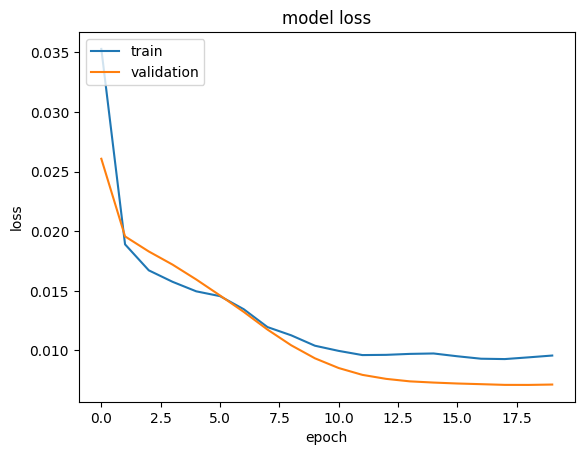

In [66]:
# print the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [67]:
predict2 = model2.predict(x_test)
predict2.shape

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(1798, 1)

In [68]:
predict2 = scaler.inverse_transform(predict2)

In [69]:
# calculate root mean squared error
y_test = scaler.inverse_transform(y_test)
rmse2 = math.sqrt(mean_squared_error(y_test, predict2))
print('Test RMSE: %.3f' % rmse2)


Test RMSE: 4.028


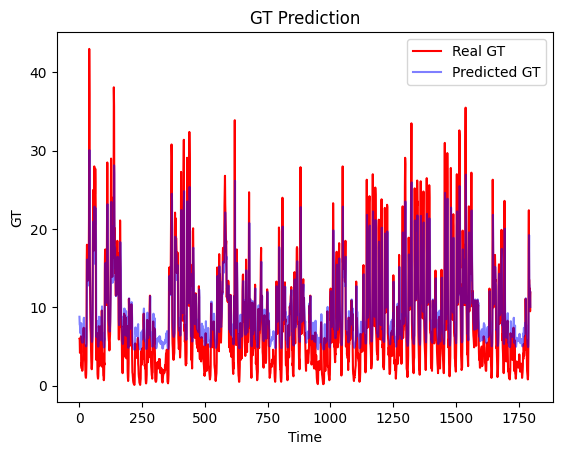

In [70]:
# plot the data
plt.plot(y_test, color = 'red', label = 'Real GT')
plt.plot(predict2, color = 'blue', label = 'Predicted GT', alpha=0.5)
plt.title('GT Prediction')

plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.show()

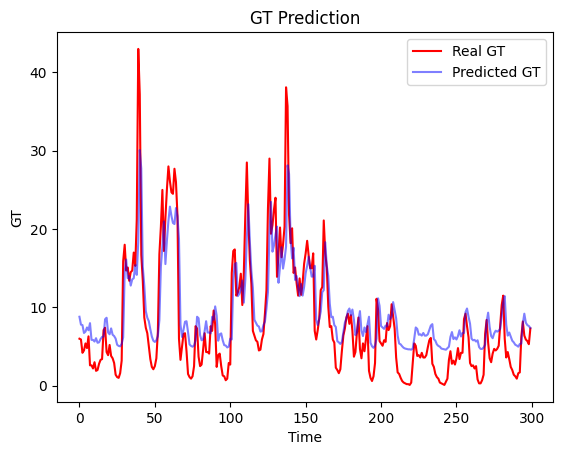

In [71]:
# plot the data
plt.plot(y_test[:300], color = 'red', label = 'Real GT')
plt.plot(predict2[:300], color = 'blue', label = 'Predicted GT', alpha=0.5)
plt.title('GT Prediction')

plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.show()